In [5]:
!pip install torch torch_geometric -q


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [131]:
import torch
import datetime
import torch.nn as nn
from torch_geometric.nn import SAGEConv,GCNConv,GATConv,GINConv, Linear
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import (
    Data,
    InMemoryDataset
)

# from google.colab import drive
# drive.mount('/content/drive')

# **GraphSAGE (Abdelrahman Wael 236319)**

In [86]:
data = torch.load(r"C:\Year Three\Semester One\Artificial Neural Network\Dataset\aml_graph.pt", weights_only=False)

In [4]:
data

Data(x=[101174, 1], edge_index=[2, 70460], edge_attr=[70460, 4], y=[101174], train_mask=[101174], val_mask=[101174], test_mask=[101174])

## GraphSAGE Setup

In [5]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5, aggr='mean'):
        super(GraphSAGE, self).__init__()
        self.convs = nn.ModuleList()
        self.num_layers = num_layers
        self.dropout = dropout

        self.convs.append(SAGEConv(in_channels, hidden_channels, aggr=aggr))
        for i in range(num_layers-2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, aggr=aggr))
        self.convs.append(SAGEConv(hidden_channels, out_channels, aggr=aggr))


    def forward(self, x, edge_index):
        for i in range(self.num_layers-1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

In [6]:
criterion = nn.CrossEntropyLoss()
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
def test(model):
  model.eval()
  with torch.no_grad():
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)

      #Compute the accuracy score for the model on training, validation, testing sets and validation loss
      train_acc = accuracy_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy())
      val_acc = accuracy_score(data.y[data.val_mask].numpy(), pred[data.val_mask].numpy())
      test_acc = accuracy_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy())
      val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

      #Compute the f1-score for the model on training, validation, testing sets and testing loss
      train_f1 = f1_score(data.y[data.train_mask].numpy(), pred[data.train_mask].numpy(), average='weighted')
      val_f1 = f1_score(data.y[data.val_mask].numpy(), pred[data.val_mask].numpy(), average='weighted')
      test_f1 = f1_score(data.y[data.test_mask].numpy(), pred[data.test_mask].numpy(), average='weighted')
      test_loss = criterion(out[data.test_mask], data.y[data.test_mask])

      return train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, val_loss, test_loss

## Default GraphSAGE
- hidden_channels = 64
- Number of layers = 2
- Dropout Rate = 0.5
- Aggregation Function = 'mean'
- Learning Rate = 0.01

In [8]:
#Train the default GraphSAGE model using 2 SAGEConv layers, dropout rate = 0.5, and mean aggregation function
graphsage1 = GraphSAGE(in_channels=data.num_features,
                   hidden_channels=64,
                   out_channels=2)
optimizer1 = torch.optim.Adam(graphsage1.parameters(), lr=0.01)

In [9]:
writer = SummaryWriter(log_dir="runs/graphsage1")

In [10]:
epoch_num = 200
training_accuaracies = []
validation_accuaracies = []
training_f1_scores = []
validation_f1_scores = []
train_losses = []
validation_losses = []
test_losses = []

for epoch in range(epoch_num):
    train_loss = train(graphsage1, optimizer1)
    train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, val_loss, test_loss = test(graphsage1)

    training_accuaracies.append(train_acc)
    validation_accuaracies.append(val_acc)

    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    test_losses.append(test_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/val", train_acc, epoch)

    if epoch % 10 == 0:
        print(f'Epoch number: {epoch}')
        print(f'Train Loss = {train_loss}, Validation Loss = {val_loss}')
        print(f'Train Accuracy = {train_acc}, Validation Accuracy = {val_acc}')
        print(f'Train F1-Score = {train_f1}, Validation F1-Score = {val_f1}')
        print("")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_31572\1460786188.py:9: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  return loss.item()


Epoch number: 0
Train Loss = 0.9737220406532288, Validation Loss = 0.7406806349754333
Train Accuracy = 0.4139784281990141, Validation Accuracy = 0.40772956410002964
Train F1-Score = 0.24240559204628145, Validation F1-Score = 0.23618655412338468

Epoch number: 10
Train Loss = 0.6987112760543823, Validation Loss = 0.6832653880119324
Train Accuracy = 0.5239872002372157, Validation Accuracy = 0.5204111890876743
Train F1-Score = 0.5230415682869138, Validation F1-Score = 0.5204024363801139

Epoch number: 20
Train Loss = 0.6786643862724304, Validation Loss = 0.6629793047904968
Train Accuracy = 0.631191391047579, Validation Accuracy = 0.632796283483246
Train F1-Score = 0.5878204667239441, Validation F1-Score = 0.5901925887575631

Epoch number: 30
Train Loss = 0.6663216352462769, Validation Loss = 0.6603705883026123
Train Accuracy = 0.6347496262617527, Validation Accuracy = 0.6365523376495008
Train F1-Score = 0.5936311815295733, Validation F1-Score = 0.5964791651975353

Epoch number: 40
Train L

In [12]:
writer.close()

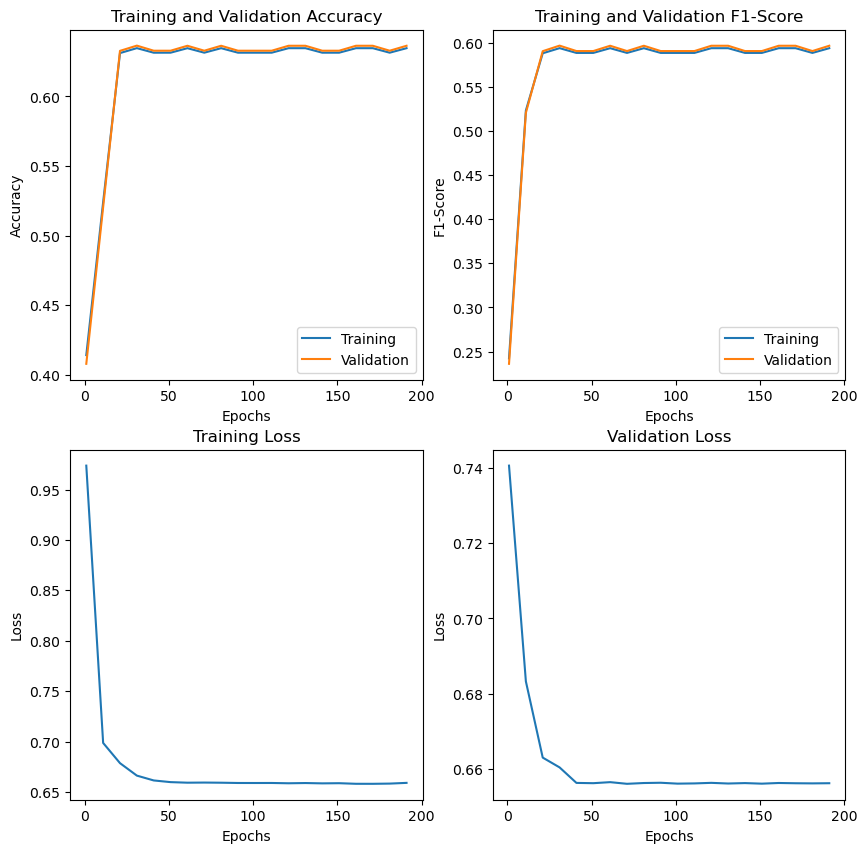

In [13]:
#Showing the learning curves
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(1,epoch_num, 10), training_accuaracies[::10])
plt.plot(range(1,epoch_num, 10), validation_accuaracies[::10])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,2)
plt.plot(range(1,epoch_num, 10), training_f1_scores[::10])
plt.plot(range(1,epoch_num, 10), validation_f1_scores[::10])
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,3)
plt.plot(range(1,epoch_num, 10), train_losses[::10])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(range(1,epoch_num, 10), validation_losses[::10])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [14]:
print(f'Testing Accuracy = {test_acc}')
print(f'Testing F1-Score = {test_f1}')

Testing Accuracy = 0.6312512354220201
Testing F1-Score = 0.5884402093214234


In [15]:
y_test = data.y[data.test_mask].numpy()
y_pred = graphsage1(data.x, data.edge_index).argmax(dim=1)[data.test_mask].numpy()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74      5893
           1       0.64      0.27      0.38      4225

    accuracy                           0.63     10118
   macro avg       0.63      0.58      0.56     10118
weighted avg       0.63      0.63      0.59     10118



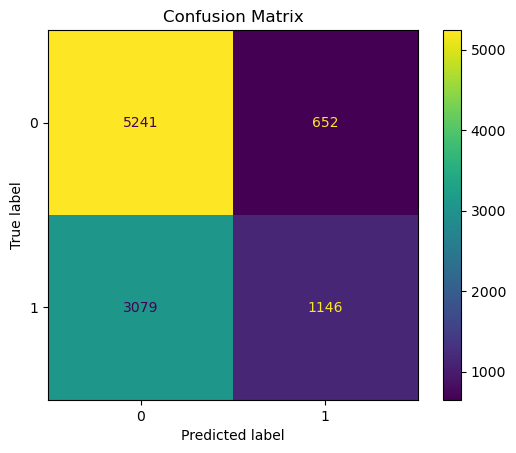

In [16]:
confusion = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion)
cm.plot()
plt.title('Confusion Matrix')
plt.show()

## GraphSAGE2
- hidden_channels = 128
- Number of layers = 2
- Dropout Rate = 0.7
- Aggregation Function = 'max'
- Learning Rate = 0.05

In [17]:
#Increase the number hidden_channels from 64 to 128 and increasing the lr
graphsage2 = GraphSAGE(in_channels=data.num_features,
                   hidden_channels=128,
                   out_channels=2,
                   num_layers=2,
                   dropout=0.7,
                   aggr='max')
optimizer2 = torch.optim.Adam(graphsage2.parameters(), lr=0.05)

In [18]:
writer = SummaryWriter(log_dir="runs/graphsage2")

In [19]:
epoch_num = 200
training_accuaracies = []
validation_accuaracies = []
training_f1_scores = []
validation_f1_scores = []
train_losses = []
validation_losses = []
test_losses = []

for epoch in range(epoch_num):
    train_loss = train(graphsage2, optimizer2)
    train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, val_loss, test_loss = test(graphsage2)

    training_accuaracies.append(train_acc)
    validation_accuaracies.append(val_acc)

    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    test_losses.append(test_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if epoch % 10 == 0:
        print(f'Epoch number: {epoch}')
        print(f'Train Loss = {train_loss}, Validation Loss = {val_loss}')
        print(f'Train Accuracy = {train_acc}, Validation Accuracy = {val_acc}')
        print(f'Train F1-Score = {train_f1}, Validation F1-Score = {val_f1}')
        print("")

Epoch number: 0
Train Loss = 0.8184857964515686, Validation Loss = 2.710395336151123
Train Accuracy = 0.4139784281990141, Validation Accuracy = 0.40772956410002964
Train F1-Score = 0.24240559204628145, Validation F1-Score = 0.23618655412338468

Epoch number: 10
Train Loss = 0.7072861790657043, Validation Loss = 0.745294451713562
Train Accuracy = 0.5860215718009859, Validation Accuracy = 0.5922704358999703
Train F1-Score = 0.43306003994148773, Validation F1-Score = 0.44060890830127536

Epoch number: 20
Train Loss = 0.69609534740448, Validation Loss = 0.6933836340904236
Train Accuracy = 0.5239872002372157, Validation Accuracy = 0.5204111890876743
Train F1-Score = 0.5230415682869138, Validation F1-Score = 0.5204024363801139

Epoch number: 30
Train Loss = 0.6677891612052917, Validation Loss = 0.6605343222618103
Train Accuracy = 0.6308948714463979, Validation Accuracy = 0.6325985964218642
Train F1-Score = 0.5873909313567377, Validation F1-Score = 0.5899067095442279

Epoch number: 40
Train L

In [ ]:
#Saving the model
#torch.save(graphsage2.state_dict(), r"/content/drive/MyDrive/graphsage2.pth")

In [20]:
writer.close()

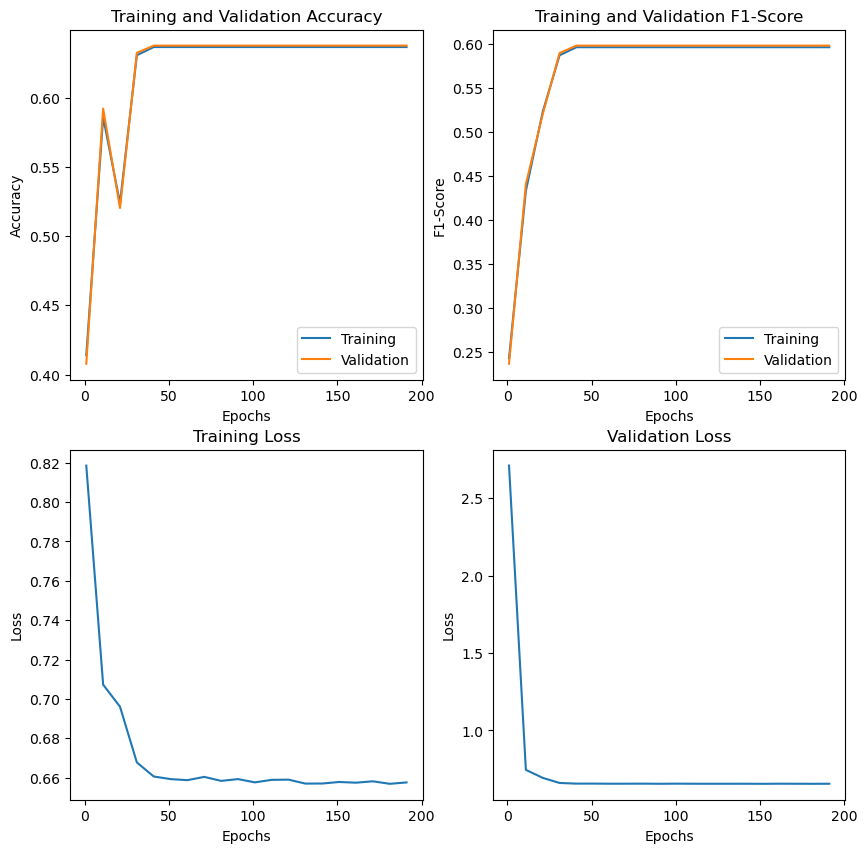

In [21]:
#Showing the learning curves
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(1,epoch_num, 10), training_accuaracies[::10])
plt.plot(range(1,epoch_num, 10), validation_accuaracies[::10])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,2)
plt.plot(range(1,epoch_num, 10), training_f1_scores[::10])
plt.plot(range(1,epoch_num, 10), validation_f1_scores[::10])
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,3)
plt.plot(range(1,epoch_num, 10), train_losses[::10])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(range(1,epoch_num, 10), validation_losses[::10])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [22]:
y_test = data.y[data.test_mask].numpy()
y_pred = graphsage2(data.x, data.edge_index).argmax(dim=1)[data.test_mask].numpy()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74      5893
           1       0.65      0.29      0.40      4225

    accuracy                           0.64     10118
   macro avg       0.64      0.59      0.57     10118
weighted avg       0.64      0.64      0.60     10118



In [23]:
print(f'Testing Accuracy = {test_acc}')
print(f'Testing F1-Score = {test_f1}')

Testing Accuracy = 0.6374777624036371
Testing F1-Score = 0.5978418227651725


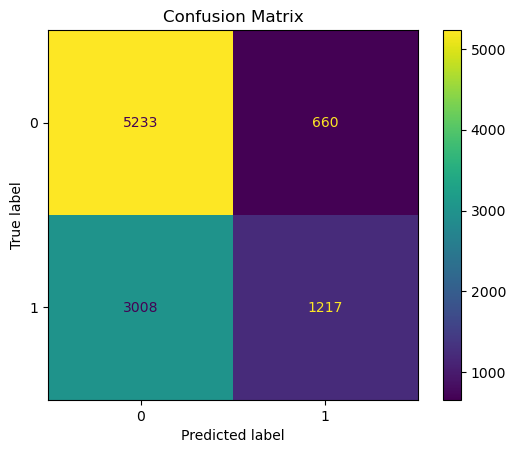

In [24]:
confusion = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion)
cm.plot()
plt.title('Confusion Matrix')
plt.show()

## GraphSAGE3
- hidden_channels = 256
- Number of layers = 2
- Dropout Rate = 0.4
- Aggregation Function = 'max'
- Learning Rate = 0.05

In [25]:
#Increase the number of layers to 3 and hidden_channels from 128 to 256
graphsage3 = GraphSAGE(in_channels=data.num_features,
                   hidden_channels=256,
                   out_channels=2,
                   num_layers=2,
                   dropout=0.4,
                   aggr='max')
optimizer3 = torch.optim.Adam(graphsage3.parameters(), lr=0.05)

In [26]:
writer = SummaryWriter(log_dir="runs/graphsage3")

In [27]:
epoch_num = 200
training_accuaracies = []
validation_accuaracies = []
training_f1_scores = []
validation_f1_scores = []
train_losses = []
validation_losses = []
test_losses = []

for epoch in range(epoch_num):
    train_loss = train(graphsage3, optimizer3)
    train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, val_loss, test_loss = test(graphsage3)

    training_accuaracies.append(train_acc)
    validation_accuaracies.append(val_acc)

    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    test_losses.append(test_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if epoch % 10 == 0:
        print(f'Epoch number: {epoch}')
        print(f'Train Loss = {train_loss}, Validation Loss = {val_loss}')
        print(f'Train Accuracy = {train_acc}, Validation Accuracy = {val_acc}')
        print(f'Train F1-Score = {train_f1}, Validation F1-Score = {val_f1}')
        print("")

Epoch number: 0
Train Loss = 0.7963468432426453, Validation Loss = 8.47872543334961
Train Accuracy = 0.4139784281990141, Validation Accuracy = 0.40772956410002964
Train F1-Score = 0.24240559204628145, Validation F1-Score = 0.23618655412338468

Epoch number: 10
Train Loss = 1.229345679283142, Validation Loss = 1.0375542640686035
Train Accuracy = 0.4139784281990141, Validation Accuracy = 0.40772956410002964
Train F1-Score = 0.24240559204628145, Validation F1-Score = 0.23618655412338468

Epoch number: 20
Train Loss = 0.7195760011672974, Validation Loss = 0.692418098449707
Train Accuracy = 0.5860215718009859, Validation Accuracy = 0.5922704358999703
Train F1-Score = 0.43306003994148773, Validation F1-Score = 0.44060890830127536

Epoch number: 30
Train Loss = 0.6787135601043701, Validation Loss = 0.6788061857223511
Train Accuracy = 0.5860215718009859, Validation Accuracy = 0.5922704358999703
Train F1-Score = 0.43306003994148773, Validation F1-Score = 0.44060890830127536

Epoch number: 40
Tr

In [28]:
#Saving the model
#torch.save(graphsage3.state_dict(), r"/content/drive/MyDrive/graphsage3.pth")

In [29]:
writer.close()

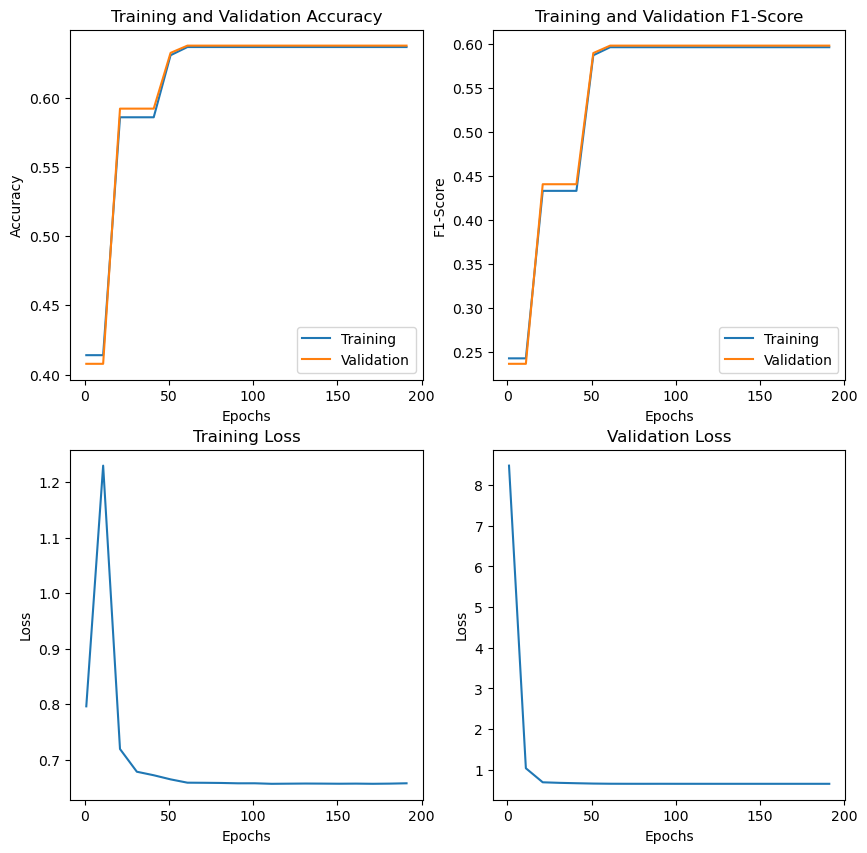

In [30]:
#Showing the learning curves
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(1,epoch_num, 10), training_accuaracies[::10])
plt.plot(range(1,epoch_num, 10), validation_accuaracies[::10])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,2)
plt.plot(range(1,epoch_num, 10), training_f1_scores[::10])
plt.plot(range(1,epoch_num, 10), validation_f1_scores[::10])
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,3)
plt.plot(range(1,epoch_num, 10), train_losses[::10])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(range(1,epoch_num, 10), validation_losses[::10])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [31]:
y_test = data.y[data.test_mask].numpy()
y_pred = graphsage3(data.x, data.edge_index).argmax(dim=1)[data.test_mask].numpy()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.89      0.74      5893
           1       0.65      0.29      0.40      4225

    accuracy                           0.64     10118
   macro avg       0.64      0.59      0.57     10118
weighted avg       0.64      0.64      0.60     10118



In [32]:
print(f'Testing Accuracy = {test_acc}')
print(f'Testing F1-Score = {test_f1}')

Testing Accuracy = 0.6374777624036371
Testing F1-Score = 0.5978418227651725


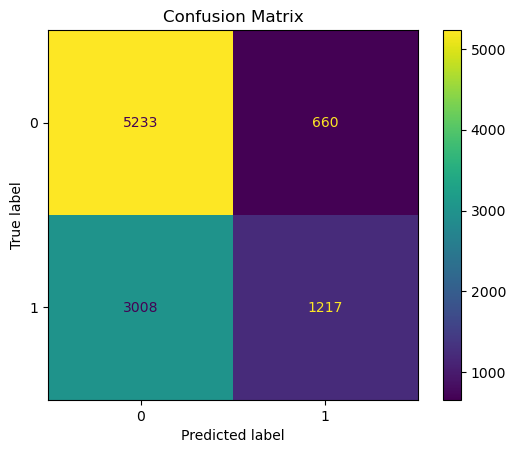

In [33]:
confusion = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion)
cm.plot()
plt.title('Confusion Matrix')
plt.show()

## GraphSAGE4
- hidden_channels = 64
- Number of layers = 3
- Dropout Rate = 0.6
- Aggregation Function = 'sum'
- Learning Rate = 0.08

In [34]:
graphsage4 = GraphSAGE(in_channels=data.num_features,
                   hidden_channels=64,
                   out_channels=2,
                   num_layers=3,
                   dropout=0.6,
                   aggr='sum')
optimizer4 = torch.optim.Adam(graphsage4.parameters(), lr=0.08)

In [35]:
writer = SummaryWriter(log_dir="runs/graphsage4")

In [36]:
epoch_num = 200
training_accuaracies = []
validation_accuaracies = []
training_f1_scores = []
validation_f1_scores = []
train_losses = []
validation_losses = []
test_losses = []

for epoch in range(epoch_num):
    train_loss = train(graphsage4, optimizer4)
    train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, val_loss, test_loss = test(graphsage4)

    training_accuaracies.append(train_acc)
    validation_accuaracies.append(val_acc)

    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    test_losses.append(test_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if epoch % 10 == 0:
        print(f'Epoch number: {epoch}')
        print(f'Train Loss = {train_loss}, Validation Loss = {val_loss}')
        print(f'Train Accuracy = {train_acc}, Validation Accuracy = {val_acc}')
        print(f'Train F1-Score = {train_f1}, Validation F1-Score = {val_f1}')
        print("")

Epoch number: 0
Train Loss = 2.5813236236572266, Validation Loss = 17.394006729125977
Train Accuracy = 0.4139784281990141, Validation Accuracy = 0.40772956410002964
Train F1-Score = 0.24240559204628145, Validation F1-Score = 0.23618655412338468

Epoch number: 10
Train Loss = 0.9945083856582642, Validation Loss = 0.8784317374229431
Train Accuracy = 0.6197877413854879, Validation Accuracy = 0.6214292774537906
Train F1-Score = 0.5312449805152607, Validation F1-Score = 0.5328175195052423

Epoch number: 20
Train Loss = 0.6800212264060974, Validation Loss = 0.6809864640235901
Train Accuracy = 0.5882948887433747, Validation Accuracy = 0.593950775921716
Train F1-Score = 0.43833498374224755, Validation F1-Score = 0.44459763721663936

Epoch number: 30
Train Loss = 0.6759713292121887, Validation Loss = 0.6758541464805603
Train Accuracy = 0.5878995292751331, Validation Accuracy = 0.5937530888603341
Train F1-Score = 0.4374003434179853, Validation F1-Score = 0.4439741285943765

Epoch number: 40
Trai

In [37]:
#Saving the model
#torch.save(graphsage4.state_dict(), r"/content/drive/MyDrive/graphsage4.pth")

In [38]:
writer.close()

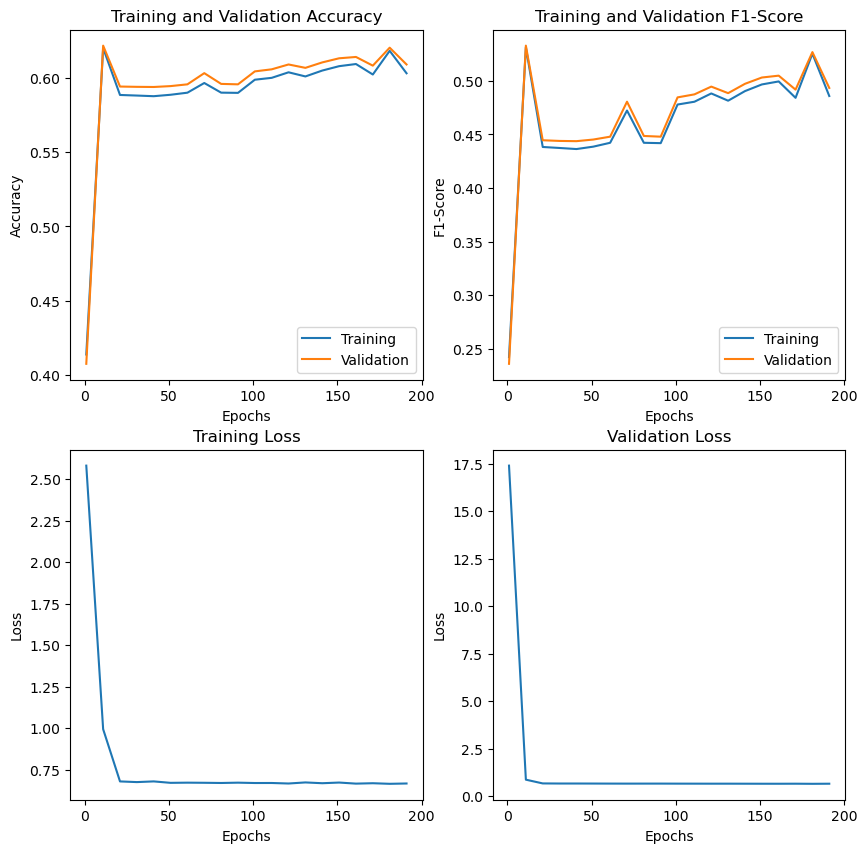

In [39]:
#Showing the learning curves
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(1,epoch_num, 10), training_accuaracies[::10])
plt.plot(range(1,epoch_num, 10), validation_accuaracies[::10])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,2)
plt.plot(range(1,epoch_num, 10), training_f1_scores[::10])
plt.plot(range(1,epoch_num, 10), validation_f1_scores[::10])
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,3)
plt.plot(range(1,epoch_num, 10), train_losses[::10])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(range(1,epoch_num, 10), validation_losses[::10])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [40]:
y_test = data.y[data.test_mask].numpy()
y_pred = graphsage4(data.x, data.edge_index).argmax(dim=1)[data.test_mask].numpy()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.97      0.75      5893
           1       0.77      0.13      0.22      4225

    accuracy                           0.62     10118
   macro avg       0.69      0.55      0.48     10118
weighted avg       0.67      0.62      0.53     10118



In [41]:
print(f'Testing Accuracy = {test_acc}')
print(f'Testing F1-Score = {test_f1}')

Testing Accuracy = 0.6189958489820122
Testing F1-Score = 0.5259360057474861


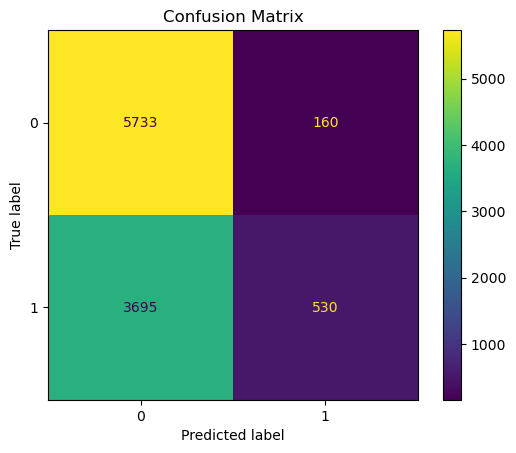

In [42]:
confusion = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion)
cm.plot()
plt.title('Confusion Matrix')
plt.show()

## GraphSAGE5
- hidden_channels = 128
- Number of layers = 2
- Dropout Rate = 0.7
- Aggregation Function = 'sum'
- Learning Rate = 0.01

In [43]:
graphsage5 = GraphSAGE(in_channels=data.num_features,
                   hidden_channels=128,
                   out_channels=2,
                   num_layers=2,
                   dropout=0.7,
                   aggr='sum')
optimizer5 = torch.optim.Adam(graphsage5.parameters(), lr=0.01)

In [44]:
writer = SummaryWriter(log_dir="runs/graphsage5")

In [45]:
epoch_num = 200
training_accuaracies = []
validation_accuaracies = []
training_f1_scores = []
validation_f1_scores = []
train_losses = []
validation_losses = []
test_losses = []

for epoch in range(epoch_num):
    train_loss = train(graphsage5, optimizer5)
    train_acc, val_acc, test_acc, train_f1, val_f1, test_f1, val_loss, test_loss = test(graphsage5)

    training_accuaracies.append(train_acc)
    validation_accuaracies.append(val_acc)

    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    test_losses.append(test_loss)

    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    if epoch % 10 == 0:
        print(f'Epoch number: {epoch}')
        print(f'Train Loss = {train_loss}, Validation Loss = {val_loss}')
        print(f'Train Accuracy = {train_acc}, Validation Accuracy = {val_acc}')
        print(f'Train F1-Score = {train_f1}, Validation F1-Score = {val_f1}')
        print("")

Epoch number: 0
Train Loss = 0.9621548652648926, Validation Loss = 0.7053102850914001
Train Accuracy = 0.616427185905435, Validation Accuracy = 0.6189581891865178
Train F1-Score = 0.5212683062178886, Validation F1-Score = 0.5234894460914745

Epoch number: 10
Train Loss = 0.7045668363571167, Validation Loss = 0.6688145399093628
Train Accuracy = 0.621529794042427, Validation Accuracy = 0.6240980527824453
Train F1-Score = 0.5319081663345528, Validation F1-Score = 0.5347202836131886

Epoch number: 20
Train Loss = 0.7023067474365234, Validation Loss = 0.6875799298286438
Train Accuracy = 0.6389256106450537, Validation Accuracy = 0.6390234259167737
Train F1-Score = 0.602929959073364, Validation F1-Score = 0.6036177560460924

Epoch number: 30
Train Loss = 0.7433846592903137, Validation Loss = 0.6550965309143066
Train Accuracy = 0.6264347224452983, Validation Accuracy = 0.628051794010082
Train F1-Score = 0.5423124806453521, Validation F1-Score = 0.5435308634234363

Epoch number: 40
Train Loss =

In [46]:
#Saving the model
#torch.save(graphsage5.state_dict(), r"/content/drive/MyDrive/graphsage5.pth")

In [47]:
writer.close()

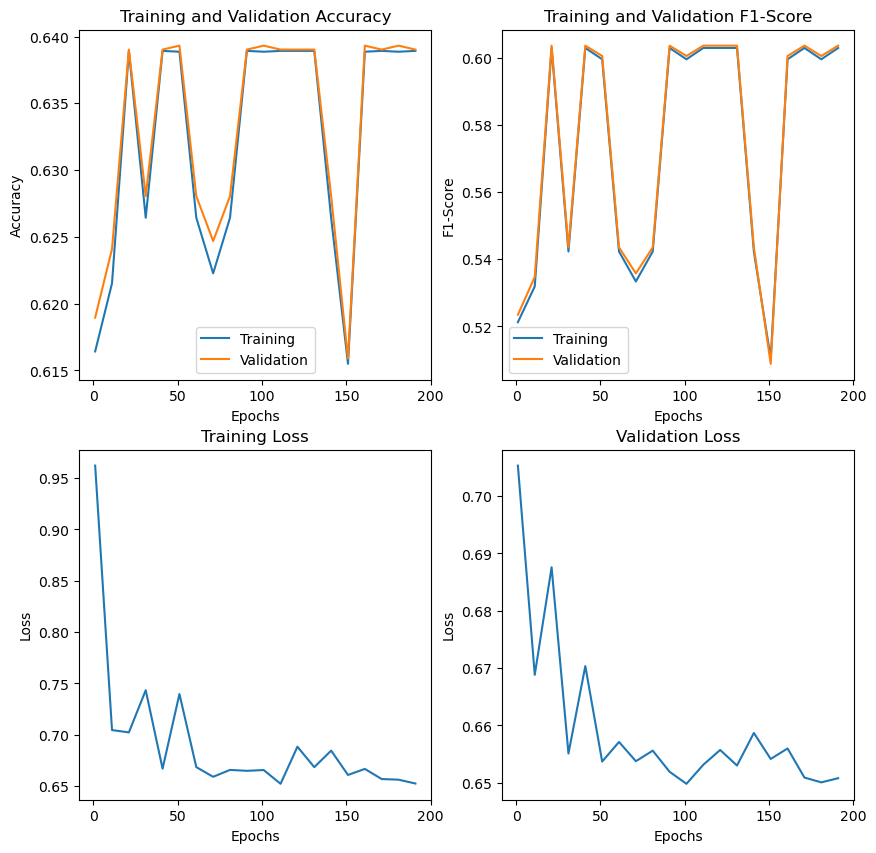

In [48]:
#Showing the learning curves
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(range(1,epoch_num, 10), training_accuaracies[::10])
plt.plot(range(1,epoch_num, 10), validation_accuaracies[::10])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,2)
plt.plot(range(1,epoch_num, 10), training_f1_scores[::10])
plt.plot(range(1,epoch_num, 10), validation_f1_scores[::10])
plt.title('Training and Validation F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend(['Training', 'Validation'])

plt.subplot(2,2,3)
plt.plot(range(1,epoch_num, 10), train_losses[::10])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2,2,4)
plt.plot(range(1,epoch_num, 10), validation_losses[::10])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [49]:
print(f'Testing Accuracy = {test_acc}')
print(f'Testing F1-Score = {test_f1}')

Testing Accuracy = 0.6394544376358964
Testing F1-Score = 0.6008167561461835


In [50]:
y_test = data.y[data.test_mask].numpy()
y_pred = graphsage5(data.x, data.edge_index).argmax(dim=1)[data.test_mask].numpy()
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.89      0.74      5893
           1       0.65      0.29      0.40      4225

    accuracy                           0.64     10118
   macro avg       0.64      0.59      0.57     10118
weighted avg       0.64      0.64      0.60     10118



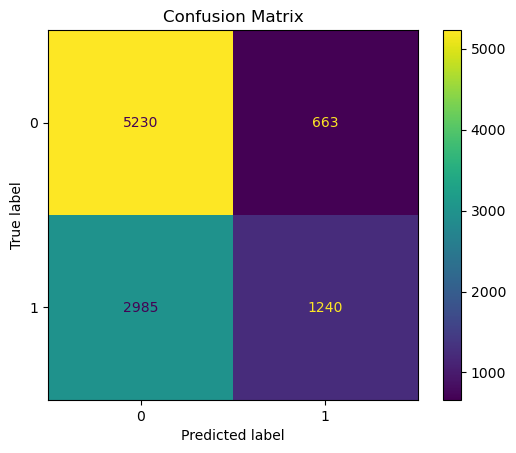

In [51]:
confusion = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(confusion)
cm.plot()
plt.title('Confusion Matrix')
plt.show()

# **GAT (Moaz Eslam 235960)**

In [52]:
writer = SummaryWriter(log_dir="runs/aml_experiment_GAT_1")

In [53]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.01)
        self.conv2 = GATConv(hidden_channels * heads, int(hidden_channels/4), heads=1, concat=False, dropout=0.6)
        self.lin = Linear(int(hidden_channels/4), out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, edge_index, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        x = self.lin(x)
        x = self.sigmoid(x)

        return x

In [54]:
# Fix dtypes (IMPORTANT)
data.x = data.x.float()
data.edge_attr = data.edge_attr.float()
data.y = data.y.float()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Split
# split = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0)
# data = split(data)
data = data.to(device)

# Model
model = GAT(
    in_channels=data.num_features,
    hidden_channels=32,
    out_channels=1,
    heads=16
).to(device)

# --------- NEW LOSS FUNCTION ----------
criterion = torch.nn.BCEWithLogitsLoss()
# --------------------------------------

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

epoch = 200

# FULL-BATCH TRAINING
for e in range(epoch):

    model.train()
    optimizer.zero_grad()

    # -------- no Sigmoid here ----------
    pred = model(data.x, data.edge_index, data.edge_attr).squeeze()

    loss = criterion(pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if e % 10 == 0:
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.edge_attr).squeeze()

            # -------- apply Sigmoid ONLY for accuracy ----------
            pred_label = (torch.sigmoid(out) > 0.5).float()

            correct = (pred_label[data.val_mask] == data.y[data.val_mask]).sum().item()
            total = int(data.val_mask.sum())
            acc = correct / total
            writer.add_scalar("Loss/train", loss.item(), e)
            writer.add_scalar("Accuracy/val", acc, e)

        print(f"Epoch {e:03d} | Loss = {loss.item():.4f} | Val Acc = {acc:.4f}")
writer.close()

Epoch 000 | Loss = 0.7614 | Val Acc = 0.4077
Epoch 010 | Loss = 0.6979 | Val Acc = 0.5923
Epoch 020 | Loss = 0.6933 | Val Acc = 0.5923
Epoch 030 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 040 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 050 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 060 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 070 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 080 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 090 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 100 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 110 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 120 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 130 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 140 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 150 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 160 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 170 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 180 | Loss = 0.6932 | Val Acc = 0.5923
Epoch 190 | Loss = 0.6932 | Val Acc = 0.5923


In [55]:
writer = SummaryWriter(log_dir="runs/aml_experiment_GATv2_2")

In [56]:
class GraphAttentionV2Layer(nn.Module):
  def __init__(self, in_features: int, out_features: int, n_heads: int,is_concat: bool = True,
                dropout: float = 0.6,
                leaky_relu_negative_slope: float = 0.2,
                share_weights: bool = False):
    super().__init__()
    self.is_concat = is_concat
    self.n_heads = n_heads
    self.share_weights = share_weights
    if is_concat:
      assert out_features % n_heads == 0
      self.n_hidden = out_features // n_heads
    else:
      self.n_hidden = out_features
    self.linear_l = nn.Linear(in_features, self.n_hidden * n_heads, bias=False)
    if share_weights:
      self.linear_r = self.linear_l
    else:
      self.linear_r = nn.Linear(in_features, self.n_hidden * n_heads, bias=False)
    self.attn = nn.Linear(self.n_hidden, 1, bias=False)
    self.activation = nn.LeakyReLU(negative_slope=leaky_relu_negative_slope)
    self.softmax = nn.Softmax(dim=1)
    self.dropout = nn.Dropout(dropout)

  def forward(self, h: torch.Tensor, adj_mat: torch.Tensor):
    n_nodes = h.shape[0]
    g_l = self.linear_l(h).view(n_nodes, self.n_heads, self.n_hidden)
    g_r = self.linear_r(h).view(n_nodes, self.n_heads, self.n_hidden)
    g_l_repeat = g_l.repeat(n_nodes, 1, 1)
    g_r_repeat_interleave = g_r.repeat_interleave(n_nodes, dim=0)
    g_sum = g_l_repeat + g_r_repeat_interleave
    g_sum = g_sum.view(n_nodes, n_nodes, self.n_heads, self.n_hidden)
    e = self.attn(self.activation(g_sum))
    e = e.squeeze(-1)
    assert adj_mat.shape[0] == 1 or adj_mat.shape[0] == n_nodes
    assert adj_mat.shape[1] == 1 or adj_mat.shape[1] == n_nodes
    assert adj_mat.shape[2] == 1 or adj_mat.shape[2] == self.n_heads
    e = e.masked_fill(adj_mat == 0, float('-inf'))
    a = self.softmax(e)
    a = self.dropout(a)
    attn_res = torch.einsum('ijh,jhf->ihf', a, g_r)
    if self.is_concat:
      return attn_res.reshape(n_nodes, self.n_heads * self.n_hidden)
    else:
      return attn_res.mean(dim=1)


In [57]:
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
import torch


class GATv2Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=0.01)
        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()

In [58]:
model = GATv2Model(
    in_channels=data.num_features,
    hidden_channels=32,
    out_channels=1,
    heads=16
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epoch = 200

for e in range(epoch):
    model.train()
    optimizer.zero_grad()

    pred = model(data.x, data.edge_index)
    loss = criterion(pred[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    if e % 20 == 0:
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred_label = (torch.sigmoid(out) > 0.5).float()

            correct = (pred_label[data.val_mask] == data.y[data.val_mask]).sum().item()
            total = int(data.val_mask.sum())
            acc = correct / total
            writer.add_scalar("Loss/train", loss.item(), e)
            writer.add_scalar("Accuracy/val", acc, e)

        print(f"Epoch {e:03d} | Loss = {loss.item():.4f} | Val Acc = {acc:.4f}")
writer.close()

Epoch 000 | Loss = 0.6787 | Val Acc = 0.5923
Epoch 020 | Loss = 0.6784 | Val Acc = 0.5923
Epoch 040 | Loss = 0.6784 | Val Acc = 0.5923
Epoch 060 | Loss = 0.6784 | Val Acc = 0.5923
Epoch 080 | Loss = 0.6784 | Val Acc = 0.5923
Epoch 100 | Loss = 0.6784 | Val Acc = 0.5923
Epoch 120 | Loss = 0.6782 | Val Acc = 0.5923
Epoch 140 | Loss = 0.6784 | Val Acc = 0.5923
Epoch 160 | Loss = 0.6782 | Val Acc = 0.5923
Epoch 180 | Loss = 0.6783 | Val Acc = 0.5923


In [59]:
from sklearn.metrics import classification_report
import numpy as np

# --- Evaluation after full training ---
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs  = torch.sigmoid(logits)
    preds  = (probs > 0.5).float().cpu().numpy()

    true = data.y.cpu().numpy()
    mask = data.val_mask.cpu().numpy()   # نستخدم فقط الـ validation mask

# Apply mask
preds_masked = preds[mask == True]
true_masked  = true[mask == True]

# --- Classification Report ---
print("\n===== Classification Report =====")
print(classification_report(true_masked, preds_masked, digits=4))


===== Classification Report =====
              precision    recall  f1-score   support

         0.0     0.5923    1.0000    0.7439      5992
         1.0     0.0000    0.0000    0.0000      4125

    accuracy                         0.5923     10117
   macro avg     0.2961    0.5000    0.3720     10117
weighted avg     0.3508    0.5923    0.4406     10117



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
writer = SummaryWriter(log_dir="runs/aml_experiment_GATv2_3")

In [61]:
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
import torch


class GATv2Deep(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 n_layers=3, heads=8, dropout=0.01):
        super().__init__()

        self.layers = nn.ModuleList()

        # ----- Layer 1 (input → hidden) -----
        self.layers.append(
            GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        )

        # ----- Middle layers (hidden → hidden) -----
        for _ in range(n_layers - 2):
            self.layers.append(
                GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
            )

        # ----- Final layer (hidden → output) -----
        self.layers.append(
            GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        )

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.layers):
            x = conv(x, edge_index)
            if i != len(self.layers) - 1:   # آخر layer بدون ReLU
                x = torch.relu(x)
        return x.squeeze()


In [62]:
model = GATv2Deep(
    in_channels=data.num_features,
    hidden_channels=64,
    out_channels=1,
    n_layers=3,
    heads=8
).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 200

for e in range(epoch):
    model.train()
    optimizer.zero_grad()

    pred = model(data.x, data.edge_index)
    loss = criterion(pred[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    if e % 20 == 0:
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred_label = (torch.sigmoid(out) > 0.5).float()

            correct = (pred_label[data.val_mask] == data.y[data.val_mask]).sum().item()
            total = int(data.val_mask.sum())
            acc = correct / total
            writer.add_scalar("Loss/train", loss.item(), e)
            writer.add_scalar("Accuracy/val", acc, e)

        print(f"Epoch {e:03d} | Loss = {loss.item():.4f} | Val Acc = {acc:.4f}")
writer.close()

Epoch 000 | Loss = 0.6988 | Val Acc = 0.5923
Epoch 020 | Loss = 0.6890 | Val Acc = 0.5923
Epoch 040 | Loss = 0.6791 | Val Acc = 0.5923
Epoch 060 | Loss = 0.6778 | Val Acc = 0.5923
Epoch 080 | Loss = 0.6777 | Val Acc = 0.5923
Epoch 100 | Loss = 0.6772 | Val Acc = 0.5923
Epoch 120 | Loss = 0.6770 | Val Acc = 0.5923
Epoch 140 | Loss = 0.6768 | Val Acc = 0.5923
Epoch 160 | Loss = 0.6764 | Val Acc = 0.5923
Epoch 180 | Loss = 0.6760 | Val Acc = 0.5923


In [63]:
from sklearn.metrics import classification_report
import numpy as np

# --- Evaluation after full training ---
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs  = torch.sigmoid(logits)
    preds  = (probs > 0.5).float().cpu().numpy()

    true = data.y.cpu().numpy()
    mask = data.val_mask.cpu().numpy()   # نستخدم فقط الـ validation mask

# Apply mask
preds_masked = preds[mask == True]
true_masked  = true[mask == True]

# --- Classification Report ---
print("\n===== Classification Report =====")
print(classification_report(true_masked, preds_masked, digits=4))



===== Classification Report =====
              precision    recall  f1-score   support

         0.0     0.5923    1.0000    0.7439      5992
         1.0     0.0000    0.0000    0.0000      4125

    accuracy                         0.5923     10117
   macro avg     0.2961    0.5000    0.3720     10117
weighted avg     0.3508    0.5923    0.4406     10117



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [148]:
writer = SummaryWriter(log_dir="runs/aml_experiment_GATv2_4")

In [149]:
import torch


class GATv2Deep(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 n_layers=3, heads=8, dropout=0.01):
        super().__init__()

        self.layers = nn.ModuleList()

        # ----- Layer 1 (input → hidden) -----
        self.layers.append(
            GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        )

        # ----- Middle layers (hidden → hidden) -----
        for _ in range(n_layers - 2):
            self.layers.append(
                GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
            )

        # ----- Final layer (hidden → output) -----
        self.layers.append(
            GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        )

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.layers):
            x = conv(x, edge_index)
            if i != len(self.layers) - 1:   # آخر layer بدون ReLU
                x = torch.relu(x)
        return x.squeeze()

In [150]:
model = GATv2Deep(
    in_channels=data.num_features,
    hidden_channels=128,
    out_channels=1,
    n_layers=3,
    heads=8
).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 200

for e in range(epoch):
    model.train()
    optimizer.zero_grad()

    pred = model(data.x, data.edge_index)
    loss = criterion(pred[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optimizer.step()

    if e % 20 == 0:
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            pred_label = (torch.sigmoid(out) > 0.5).float()

            correct = (pred_label[data.val_mask] == data.y[data.val_mask]).sum().item()
            total = int(data.val_mask.sum())
            acc = correct / total
            writer.add_scalar("Loss/train", loss.item(), e)
            writer.add_scalar("Accuracy/val", acc, e)

        print(f"Epoch {e:03d} | Loss = {loss.item():.4f} | Val Acc = {acc:.4f}")
writer.close()

Epoch 000 | Loss = 0.7633 | Val Acc = 0.5923
Epoch 020 | Loss = 0.7368 | Val Acc = 0.5923
Epoch 040 | Loss = 0.6812 | Val Acc = 0.5923
Epoch 060 | Loss = 0.6786 | Val Acc = 0.5923
Epoch 080 | Loss = 0.6778 | Val Acc = 0.5923
Epoch 100 | Loss = 0.6776 | Val Acc = 0.5923
Epoch 120 | Loss = 0.6771 | Val Acc = 0.5923
Epoch 140 | Loss = 0.6758 | Val Acc = 0.5923
Epoch 160 | Loss = 0.6758 | Val Acc = 0.5923
Epoch 180 | Loss = 0.6741 | Val Acc = 0.5923


In [151]:
from sklearn.metrics import classification_report
import numpy as np

# --- Evaluation after full training ---
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs  = torch.sigmoid(logits)
    preds  = (probs > 0.5).float().cpu().numpy()

    true = data.y.cpu().numpy()
    mask = data.val_mask.cpu().numpy()   # نستخدم فقط الـ validation mask

# Apply mask
preds_masked = preds[mask == True]
true_masked  = true[mask == True]

# --- Classification Report ---
print("\n===== Classification Report =====")
print(classification_report(true_masked, preds_masked, digits=4))



===== Classification Report =====
              precision    recall  f1-score   support

         0.0     0.5923    1.0000    0.7439      5992
         1.0     0.0000    0.0000    0.0000      4125

    accuracy                         0.5923     10117
   macro avg     0.2961    0.5000    0.3720     10117
weighted avg     0.3508    0.5923    0.4406     10117



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **GCN (Mohamed Khaled 235903)**

In [79]:
device = torch.device("cpu")

In [87]:
class GCN(torch.nn.Module):
  def __init__(self,in_channels,hidden_channels1,hidden_channels2,hidden_channels3,out_channels):
    super(GCN,self).__init__()
    self.conv1 = GCNConv(in_channels, hidden_channels1)
    self.bn1 = nn.BatchNorm1d(hidden_channels1)
      
    self.conv2 = GCNConv(hidden_channels1, hidden_channels2)
    self.bn2 = nn.BatchNorm1d(hidden_channels2)  

    self.conv3 = GCNConv(hidden_channels2, hidden_channels3)
    self.bn3 = nn.BatchNorm1d(hidden_channels3) 

    self.conv4 = GCNConv(hidden_channels3, out_channels)

  def forward(self,x,edge_index):
    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.relu(x)
    x = F.dropout(x, p= 0.5, training=self.training)
      
    x = self.conv2(x, edge_index)
    x = self.bn2(x) 
    x = F.relu(x)
    x = F.dropout(x, p= 0.3, training=self.training)

    x = self.conv3(x, edge_index)
    x = self.bn3(x) 
    x = F.relu(x)
    x = F.dropout(x, p= 0.7, training=self.training)  

    x = self.conv4(x, edge_index)
      
    return x

In [88]:
def train(model, optimizar):

  model.train()
  optimizar.zero_grad()
  out = model(data.x,data.edge_index)
  loss = criterion()(out[data.train_mask],data.y[data.train_mask])
  loss.backward()
  optimizar.step()
  return loss.item()

In [89]:
def test(model):
  model.eval()
  with torch.no_grad():
    out = model(data.x,data.edge_index)
    pred = out.argmax(dim=1)

    train_correct = pred[data.train_mask].eq(data.y[data.train_mask]).sum()
    test_correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum()
    val_correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum()

    train_acc = train_correct.item() / data.train_mask.sum().item()
    test_acc = test_correct.item() / data.test_mask.sum().item()
    val_acc = val_correct.item() / data.val_mask.sum().item()

    return train_acc,test_acc,val_acc

In [90]:
model_1 = GCN(in_channels=data.num_node_features,hidden_channels1=64,hidden_channels2=64,hidden_channels3=64,out_channels=2)
criterion = nn.CrossEntropyLoss
optimizar_1 = torch.optim.Adam(model_1.parameters(),lr=0.001)

In [91]:
epoch_n = 200

In [92]:
writer = SummaryWriter(log_dir="runs/GCN1")

In [93]:
# model_1 = model_1.to(device)
# data = data.to(device)
for epoch in range(epoch_n):
  loss = train(model_1, optimizar_1)
  if epoch % 20 == 0:
    train_acc,test_acc,val_acc = test(model_1)
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/val", train_acc, epoch)    
    print(f"Train Loss {loss:.4f} Train Accuracy {train_acc}")
    print(f"Train Loss {loss:.4f} Val Accuracy {val_acc}")
    print(f"Train Loss {loss:.4f} Test Accuracy {test_acc}")
writer.close()

Train Loss 0.9769 Train Accuracy 0.4139784281990141
Train Loss 0.9769 Val Accuracy 0.40772956410002964
Train Loss 0.9769 Test Accuracy 0.4175726428147855
Train Loss 0.7785 Train Accuracy 0.5943611855842054
Train Loss 0.7785 Val Accuracy 0.6015617277849165
Train Loss 0.7785 Test Accuracy 0.5954734137181261
Train Loss 0.7269 Train Accuracy 0.6055053805952632
Train Loss 0.7269 Val Accuracy 0.6096668973015716
Train Loss 0.7269 Test Accuracy 0.6070369638268432
Train Loss 0.7066 Train Accuracy 0.612387106339342
Train Loss 0.7066 Val Accuracy 0.6153998220816448
Train Loss 0.7066 Test Accuracy 0.6140541609013639
Train Loss 0.6992 Train Accuracy 0.6159329865701331
Train Loss 0.6992 Val Accuracy 0.6188593456558268
Train Loss 0.6992 Test Accuracy 0.6182051788891085
Train Loss 0.6918 Train Accuracy 0.6167607704567637
Train Loss 0.6918 Val Accuracy 0.6189581891865178
Train Loss 0.6918 Test Accuracy 0.6188970152203993
Train Loss 0.6864 Train Accuracy 0.6361457393839806
Train Loss 0.6864 Val Accuracy

In [94]:
out = model_1(data.x, data.edge_index)
pred = out.argmax(dim=1)
y_pred = pred[data.test_mask].cpu().numpy()
y_true = data.y[data.test_mask].cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      5893
           1       0.66      0.17      0.27      4225

    accuracy                           0.62     10118
   macro avg       0.64      0.55      0.51     10118
weighted avg       0.63      0.62      0.54     10118



In [95]:
writer = SummaryWriter(log_dir="runs/runs/GCN2")

In [96]:
model_2 = GCN(in_channels=data.num_node_features,hidden_channels1=128,hidden_channels2=128,hidden_channels3=128,out_channels=2)
optimizar_2 = torch.optim.Adam(model_2.parameters(),lr=0.001)

In [97]:
# model_2 = model_2.to(device)
# data = data.to(device)
for epoch in range(epoch_n):
  loss = train(model_2, optimizar_2)
  if epoch % 20 == 0:
    train_acc,test_acc,val_acc = test(model_2)  
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/val", train_acc, epoch) 
    print(f"Train Loss {loss:.4f} Train Accuracy {train_acc}")
    print(f"Train Loss {loss:.4f} Val Accuracy {val_acc}")
    print(f"Train Loss {loss:.4f} Test Accuracy {test_acc}")
writer.close()

Train Loss 1.1542 Train Accuracy 0.6135978947108316
Train Loss 1.1542 Val Accuracy 0.6165859444499358
Train Loss 1.1542 Test Accuracy 0.6177110100810437
Train Loss 0.8143 Train Accuracy 0.5860339267843685
Train Loss 0.8143 Val Accuracy 0.5922704358999703
Train Loss 0.8143 Test Accuracy 0.5824273571852144
Train Loss 0.7479 Train Accuracy 0.6052953458777598
Train Loss 0.7479 Val Accuracy 0.6097657408322625
Train Loss 0.7479 Test Accuracy 0.6075311326349081
Train Loss 0.7265 Train Accuracy 0.6132396001927377
Train Loss 0.7265 Val Accuracy 0.6161905703271721
Train Loss 0.7265 Test Accuracy 0.6158331686103973
Train Loss 0.7097 Train Accuracy 0.6190711523493001
Train Loss 0.7097 Val Accuracy 0.6197489374320451
Train Loss 0.7097 Test Accuracy 0.6213678592607235
Train Loss 0.7014 Train Accuracy 0.6194047369006289
Train Loss 0.7014 Val Accuracy 0.619847780962736
Train Loss 0.7014 Test Accuracy 0.6215655267839494
Train Loss 0.6950 Train Accuracy 0.6171931948751529
Train Loss 0.6950 Val Accuracy 

In [98]:
out = model_2(data.x, data.edge_index)
pred = out.argmax(dim=1)
y_pred = pred[data.test_mask].cpu().numpy()
y_true = data.y[data.test_mask].cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.94      0.74      5893
           1       0.66      0.18      0.28      4225

    accuracy                           0.62     10118
   macro avg       0.64      0.56      0.51     10118
weighted avg       0.63      0.62      0.55     10118



In [99]:
writer = SummaryWriter(log_dir="runs/runs/GCN3")

In [100]:
model_3 = GCN(in_channels=data.num_node_features,hidden_channels1=256,hidden_channels2=256,hidden_channels3=256,out_channels=2)
optimizar_3 = torch.optim.Adam(model_3.parameters(),lr=0.001)

In [101]:
# model_3 = model_3.to(device)
# data = data.to(device)
for epoch in range(epoch_n):
  loss = train(model_3, optimizar_3)
  if epoch % 20 == 0:
    train_acc,test_acc,val_acc = test(model_3)  
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/val", train_acc, epoch) 
    print(f"Train Loss {loss:.4f} Train Accuracy {train_acc}")
    print(f"Train Loss {loss:.4f} Val Accuracy {val_acc}")
    print(f"Train Loss {loss:.4f} Test Accuracy {test_acc}")
writer.close()

Train Loss 1.2264 Train Accuracy 0.4139784281990141
Train Loss 1.2264 Val Accuracy 0.40772956410002964
Train Loss 1.2264 Test Accuracy 0.4175726428147855
Train Loss 0.7793 Train Accuracy 0.3876252486440406
Train Loss 0.7793 Val Accuracy 0.38331521201937335
Train Loss 0.7793 Test Accuracy 0.383178493773473
Train Loss 0.7324 Train Accuracy 0.6088412261085508
Train Loss 0.7324 Val Accuracy 0.6124345161609173
Train Loss 0.7324 Test Accuracy 0.6102984779600712
Train Loss 0.7174 Train Accuracy 0.6126094960402279
Train Loss 0.7174 Val Accuracy 0.6153998220816448
Train Loss 0.7174 Test Accuracy 0.6142518284245898
Train Loss 0.7067 Train Accuracy 0.63274811895378
Train Loss 0.7067 Val Accuracy 0.635267371750519
Train Loss 0.7067 Test Accuracy 0.634809250840087
Train Loss 0.6931 Train Accuracy 0.633155833405404
Train Loss 0.6931 Val Accuracy 0.6356627458732826
Train Loss 0.6931 Test Accuracy 0.6351057521249259
Train Loss 0.6844 Train Accuracy 0.6337612275911488
Train Loss 0.6844 Val Accuracy 0.6

In [102]:
out = model_3(data.x, data.edge_index)
pred = out.argmax(dim=1)
y_pred = pred[data.test_mask].cpu().numpy()
y_true = data.y[data.test_mask].cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75      5893
           1       0.70      0.20      0.31      4225

    accuracy                           0.63     10118
   macro avg       0.66      0.57      0.53     10118
weighted avg       0.65      0.63      0.57     10118



In [103]:
writer = SummaryWriter(log_dir="runs/runs/GCN4")

In [104]:
model_4 = GCN(in_channels=data.num_node_features,hidden_channels1=512,hidden_channels2=512,hidden_channels3=512,out_channels=2)
optimizar_4 = torch.optim.Adam(model_4.parameters(),lr=0.001)

In [105]:
# model_4 = model_4.to(device)
# data = data.to(device)
for epoch in range(epoch_n):
  loss = train(model_4, optimizar_4)
  if epoch % 20 == 0:
    train_acc,test_acc,val_acc = test(model_4)  
    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Accuracy/val", train_acc, epoch)   
    print(f"Train Loss {loss:.4f} Train Accuracy {train_acc}")
    print(f"Train Loss {loss:.4f} Val Accuracy {val_acc}")
    print(f"Train Loss {loss:.4f} Test Accuracy {test_acc}")
writer.close()

Train Loss 1.0541 Train Accuracy 0.4139784281990141
Train Loss 1.0541 Val Accuracy 0.40772956410002964
Train Loss 1.0541 Test Accuracy 0.4175726428147855
Train Loss 0.7519 Train Accuracy 0.6337612275911488
Train Loss 0.7519 Val Accuracy 0.6367500247108827
Train Loss 0.7519 Test Accuracy 0.6350069183633129
Train Loss 0.7064 Train Accuracy 0.41365719863106787
Train Loss 0.7064 Val Accuracy 0.40763072056933874
Train Loss 0.7064 Test Accuracy 0.41717730776833367
Train Loss 0.6892 Train Accuracy 0.5218127231618873
Train Loss 0.6892 Val Accuracy 0.5200158149649106
Train Loss 0.6892 Test Accuracy 0.51798774461356
Train Loss 0.6850 Train Accuracy 0.6331187684552564
Train Loss 0.6850 Val Accuracy 0.6359592764653553
Train Loss 0.6850 Test Accuracy 0.6346115833168611
Train Loss 0.6744 Train Accuracy 0.6148210380657038
Train Loss 0.6744 Val Accuracy 0.6183651280023722
Train Loss 0.6744 Test Accuracy 0.61059497924491
Train Loss 0.6665 Train Accuracy 0.633155833405404
Train Loss 0.6665 Val Accuracy 

In [106]:
out = model_4(data.x, data.edge_index)
pred = out.argmax(dim=1)
y_pred = pred[data.test_mask].cpu().numpy()
y_true = data.y[data.test_mask].cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.94      0.75      5893
           1       0.71      0.21      0.33      4225

    accuracy                           0.63     10118
   macro avg       0.67      0.57      0.54     10118
weighted avg       0.66      0.63      0.57     10118



# **GAE (Ahmed Said 235703)**

In [107]:
import torch
import torch.serialization
from torch_geometric.data import Data
import numpy as np
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

def init_writer(name):
    return SummaryWriter(log_dir=f"runs/{name}")

def log_epoch_losses(writer, epoch, train_loss, test_loss):
    
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/test", test_loss, epoch)

# allow PyG Data class to load safely


In [ ]:
# torch.serialization.add_safe_globals([Data])

# path = r"C:\Users\saide\OneDrive\Desktop\aml_graph.pt"
# path = Path(path)

# print("Loading:", path)
# data = torch.load(str(path), weights_only=False)   # must set weights_only=False

# print(data)
# print("x shape:", data.x.shape)
# print("edge_index shape:", data.edge_index.shape)
# print("edge_attr shape:", data.edge_attr.shape)
# print("y shape:", data.y.shape)


In [108]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GAEEncoder(nn.Module):
    """
    Encoder used as GAE encoder: two-layer GCN that outputs latent embeddings.
    """
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, latent_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [109]:
in_channels = data.x.size(1)     # number of node features
hidden_channels = 64             # hidden layer size
latent_dim = 32                  # embedding size


In [110]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

def get_test_loss(model, data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
    return loss.item()


In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def eval_embeddings(z, data):

    z_np = z.detach().cpu().numpy()
    y_np = data.y.cpu().numpy()

    train_mask = data.train_mask.cpu().numpy()
    test_mask = data.test_mask.cpu().numpy()

    clf = LogisticRegression(max_iter=300, class_weight='balanced')
    clf.fit(z_np[train_mask], y_np[train_mask])

    y_pred = clf.predict(z_np[test_mask])

    acc = accuracy_score(y_np[test_mask], y_pred)
    f1 = f1_score(y_np[test_mask], y_pred, average='macro')

    return acc, f1, y_pred
    
def drawConfusion(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()


def plot_train_test(train_losses, test_losses, title="Train vs Test Loss"):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="train loss")
    plt.plot(test_losses, label="test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



In [112]:
from torch_geometric.nn import GAE
# base model
GrapgAutoEncoder = GAE(GAEEncoder(in_channels, hidden_channels, latent_dim))
optimizer = torch.optim.Adam(GrapgAutoEncoder.parameters(), lr=0.01)
writer1 = init_writer("Base_Model")

print(GrapgAutoEncoder)
train_losses = []
test_losses = []

for epoch in range(1, 501):

    train_loss = train(GrapgAutoEncoder, optimizer, data)
    test_loss  = get_test_loss(GrapgAutoEncoder, data)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    log_epoch_losses(writer1, epoch, train_loss, test_loss)


    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}  train_loss={train_loss:.4f}   test_loss={test_loss:.4f}")


writer1.close()




GAE(
  (encoder): GAEEncoder(
    (conv1): GCNConv(1, 64)
    (conv2): GCNConv(64, 32)
  )
  (decoder): InnerProductDecoder()
)
Epoch 010  train_loss=1.3834   test_loss=1.3819
Epoch 020  train_loss=1.3806   test_loss=1.3803
Epoch 030  train_loss=1.3760   test_loss=1.3753
Epoch 040  train_loss=1.3696   test_loss=1.3691
Epoch 050  train_loss=1.3647   test_loss=1.3645
Epoch 060  train_loss=1.3619   test_loss=1.3617
Epoch 070  train_loss=1.3599   test_loss=1.3597
Epoch 080  train_loss=1.3577   test_loss=1.3573
Epoch 090  train_loss=1.3554   test_loss=1.3552
Epoch 100  train_loss=1.3536   test_loss=1.3530
Epoch 110  train_loss=1.3517   test_loss=1.3520
Epoch 120  train_loss=1.3506   test_loss=1.3502
Epoch 130  train_loss=1.3492   test_loss=1.3484
Epoch 140  train_loss=1.3474   test_loss=1.3475
Epoch 150  train_loss=1.3456   test_loss=1.3468
Epoch 160  train_loss=1.3446   test_loss=1.3454
Epoch 170  train_loss=1.3437   test_loss=1.3430
Epoch 180  train_loss=1.3413   test_loss=1.3413
Epoch 19

In [113]:
from sklearn.metrics import accuracy_score, f1_score

z = GrapgAutoEncoder.encode(data.x, data.edge_index)
acc, f1, yPred = eval_embeddings(z, data)
print("Base model Accuracy:", acc)
print("Base model F1 Score:", f1)


Base model Accuracy: 0.6243328721091125
Base model F1 Score: 0.5045492977565924


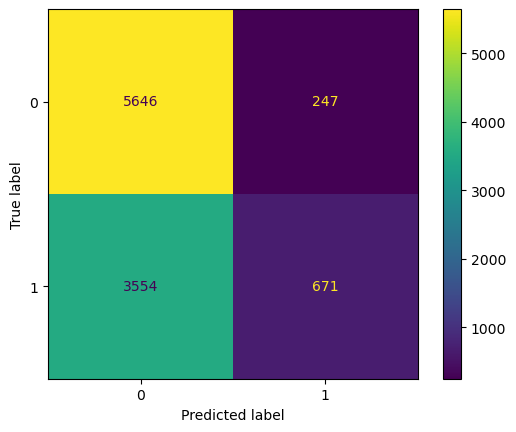

In [114]:
yTrue = data.y.cpu().numpy()[data.test_mask.cpu().numpy()]
drawConfusion(yTrue, yPred)

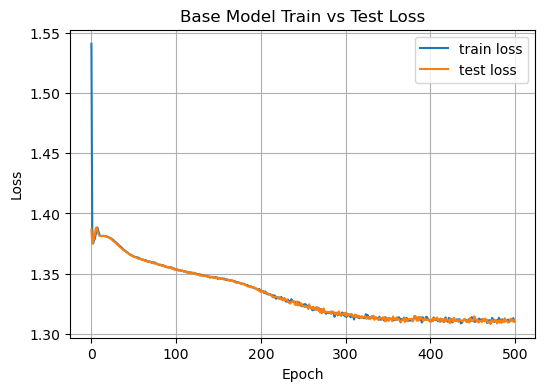

In [115]:
plot_train_test(train_losses, test_losses, title="Base Model Train vs Test Loss")

In [116]:
# Variation 1: larger latent

print("\n=== Variation 1: GAE (hidden=64, latent=64, lr=0.01) ===")
latent_dim_v1 = 64
GrapgAutoEncoder1 = GAE(GAEEncoder(in_channels, hidden_channels, latent_dim_v1))
optimizer_v1 = torch.optim.Adam(GrapgAutoEncoder1.parameters(), lr=0.01)

writer1 = init_writer("Variation1")

train_losses_v1 = []
test_losses_v1 = []

for epoch in range(1, 301):
    train_loss = train(GrapgAutoEncoder1, optimizer_v1, data)
    test_loss  = get_test_loss(GrapgAutoEncoder1, data)

    train_losses_v1.append(train_loss)
    test_losses_v1.append(test_loss)

    log_epoch_losses(writer1, epoch, train_loss, test_loss)

    if epoch % 10 == 0:
        print(f"[Var1] Epoch {epoch:03d}  train_loss={train_loss:.4f}   test_loss={test_loss:.4f}")


writer1.close()

z_v1 = GrapgAutoEncoder1.encode(data.x, data.edge_index)
acc_v1, f1_v1, yPred_v1 = eval_embeddings(z_v1, data)
print("Var1 Accuracy:", acc_v1)
print("Var1 F1 Score:", f1_v1)


=== Variation 1: GAE (hidden=64, latent=64, lr=0.01) ===
[Var1] Epoch 010  train_loss=1.3887   test_loss=1.3862
[Var1] Epoch 020  train_loss=1.3824   test_loss=1.3820
[Var1] Epoch 030  train_loss=1.3772   test_loss=1.3765
[Var1] Epoch 040  train_loss=1.3705   test_loss=1.3698
[Var1] Epoch 050  train_loss=1.3657   test_loss=1.3652
[Var1] Epoch 060  train_loss=1.3628   test_loss=1.3625
[Var1] Epoch 070  train_loss=1.3615   test_loss=1.3608
[Var1] Epoch 080  train_loss=1.3596   test_loss=1.3598
[Var1] Epoch 090  train_loss=1.3579   test_loss=1.3573
[Var1] Epoch 100  train_loss=1.3558   test_loss=1.3560
[Var1] Epoch 110  train_loss=1.3539   test_loss=1.3540
[Var1] Epoch 120  train_loss=1.3526   test_loss=1.3523
[Var1] Epoch 130  train_loss=1.3514   test_loss=1.3513
[Var1] Epoch 140  train_loss=1.3500   test_loss=1.3501
[Var1] Epoch 150  train_loss=1.3490   test_loss=1.3483
[Var1] Epoch 160  train_loss=1.3473   test_loss=1.3480
[Var1] Epoch 170  train_loss=1.3470   test_loss=1.3463
[Var1] 

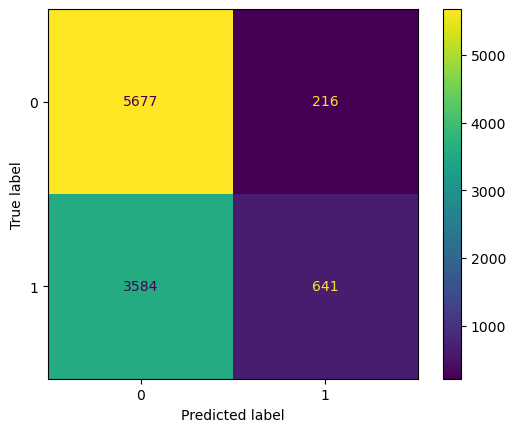

In [117]:
drawConfusion(yTrue, yPred_v1)

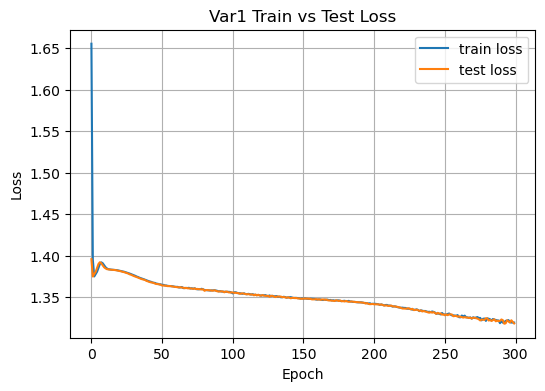

In [118]:
plot_train_test(train_losses_v1, test_losses_v1, title="Var1 Train vs Test Loss")

In [119]:
# Variation 2: larger hidden

print("\n=== Variation 2: GAE (hidden=128, latent=32, lr=0.01) ===")
hidden_channels_v2 = 128
GrapgAutoEncoder2 = GAE(GAEEncoder(in_channels, hidden_channels_v2, latent_dim))
optimizer_v2 = torch.optim.Adam(GrapgAutoEncoder2.parameters(), lr=0.01)
writer1 = init_writer("Variation2")

train_losses_v2 = []
test_losses_v2 = []

for epoch in range(1, 301):
    train_loss = train(GrapgAutoEncoder2, optimizer_v2, data)
    test_loss  = get_test_loss(GrapgAutoEncoder2, data)

    train_losses_v2.append(train_loss)
    test_losses_v2.append(test_loss)

    log_epoch_losses(writer1, epoch, train_loss, test_loss)

    if epoch % 10 == 0:
        print(f"[Var2] Epoch {epoch:03d}  train_loss={train_loss:.4f}   test_loss={test_loss:.4f}")

writer1.close()

z_v2 = GrapgAutoEncoder2.encode(data.x, data.edge_index)
acc_v2, f1_v2, yPred_v2 = eval_embeddings(z_v2, data)
print("Var2 Accuracy:", acc_v2)
print("Var2 F1 Score:", f1_v2)




=== Variation 2: GAE (hidden=128, latent=32, lr=0.01) ===
[Var2] Epoch 010  train_loss=1.3797   test_loss=1.3794
[Var2] Epoch 020  train_loss=1.3756   test_loss=1.3749
[Var2] Epoch 030  train_loss=1.3677   test_loss=1.3671
[Var2] Epoch 040  train_loss=1.3612   test_loss=1.3601
[Var2] Epoch 050  train_loss=1.3558   test_loss=1.3550
[Var2] Epoch 060  train_loss=1.3526   test_loss=1.3517
[Var2] Epoch 070  train_loss=1.3494   test_loss=1.3494
[Var2] Epoch 080  train_loss=1.3480   test_loss=1.3468
[Var2] Epoch 090  train_loss=1.3465   test_loss=1.3456
[Var2] Epoch 100  train_loss=1.3443   test_loss=1.3439
[Var2] Epoch 110  train_loss=1.3415   test_loss=1.3408
[Var2] Epoch 120  train_loss=1.3374   test_loss=1.3363
[Var2] Epoch 130  train_loss=1.3338   test_loss=1.3327
[Var2] Epoch 140  train_loss=1.3309   test_loss=1.3317
[Var2] Epoch 150  train_loss=1.3285   test_loss=1.3304
[Var2] Epoch 160  train_loss=1.3284   test_loss=1.3278
[Var2] Epoch 170  train_loss=1.3264   test_loss=1.3254
[Var2]

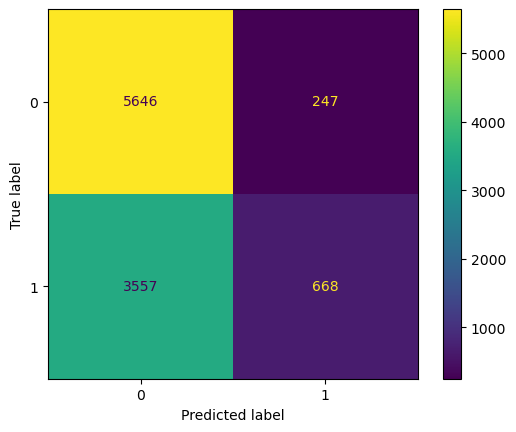

In [120]:
drawConfusion(yTrue, yPred_v2)

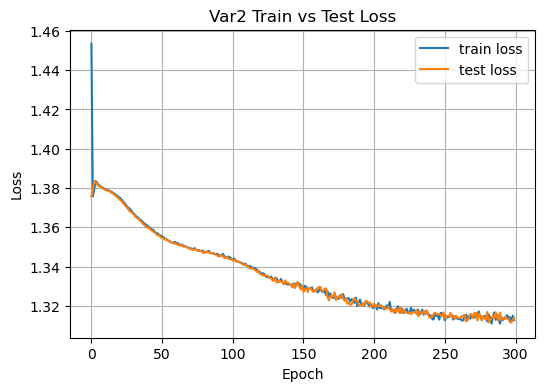

In [121]:
plot_train_test(train_losses_v2, test_losses_v2, title="Var2 Train vs Test Loss")


In [122]:
print("\n=== Variation 3: GAE (hidden=64, latent=32, lr=0.01, weight_decay=5e-4) ===")

GrapgAutoEncoder3 = GAE(GAEEncoder(in_channels, hidden_channels, latent_dim))
optimizer_v3 = torch.optim.Adam(GrapgAutoEncoder3.parameters(), lr=0.01, weight_decay=5e-4)
writer1 = init_writer("Variation3")


train_losses_v3 = []
test_losses_v3 = []

for epoch in range(1, 301):
    train_loss = train(GrapgAutoEncoder3, optimizer_v3, data)
    test_loss  = get_test_loss(GrapgAutoEncoder3, data)

    train_losses_v3.append(train_loss)
    test_losses_v3.append(test_loss)

    log_epoch_losses(writer1, epoch, train_loss, test_loss)
    
    if epoch % 10 == 0:
        print(f"[Var3] Epoch {epoch:03d}  train_loss={train_loss:.4f}   test_loss={test_loss:.4f}")

writer1.close()
z_v3 = GrapgAutoEncoder3.encode(data.x, data.edge_index)
acc_v3, f1_v3, yPred_v3 = eval_embeddings(z_v3, data)
print("Var3 Accuracy:", acc_v3)
print("Var3 F1 Score:", f1_v3)


=== Variation 3: GAE (hidden=64, latent=32, lr=0.01, weight_decay=5e-4) ===
[Var3] Epoch 010  train_loss=1.3800   test_loss=1.3804
[Var3] Epoch 020  train_loss=1.3753   test_loss=1.3742
[Var3] Epoch 030  train_loss=1.3687   test_loss=1.3682
[Var3] Epoch 040  train_loss=1.3631   test_loss=1.3626
[Var3] Epoch 050  train_loss=1.3582   test_loss=1.3575
[Var3] Epoch 060  train_loss=1.3533   test_loss=1.3534
[Var3] Epoch 070  train_loss=1.3505   test_loss=1.3507
[Var3] Epoch 080  train_loss=1.3491   test_loss=1.3483
[Var3] Epoch 090  train_loss=1.3467   test_loss=1.3465
[Var3] Epoch 100  train_loss=1.3439   test_loss=1.3434
[Var3] Epoch 110  train_loss=1.3409   test_loss=1.3408
[Var3] Epoch 120  train_loss=1.3373   test_loss=1.3377
[Var3] Epoch 130  train_loss=1.3331   test_loss=1.3332
[Var3] Epoch 140  train_loss=1.3297   test_loss=1.3284
[Var3] Epoch 150  train_loss=1.3259   test_loss=1.3261
[Var3] Epoch 160  train_loss=1.3242   test_loss=1.3232
[Var3] Epoch 170  train_loss=1.3228   test_

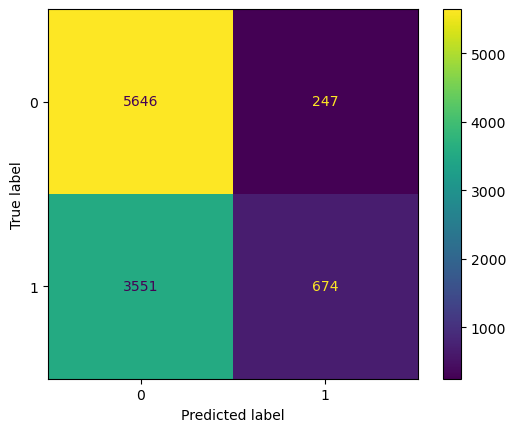

In [123]:
drawConfusion(yTrue, yPred_v3)

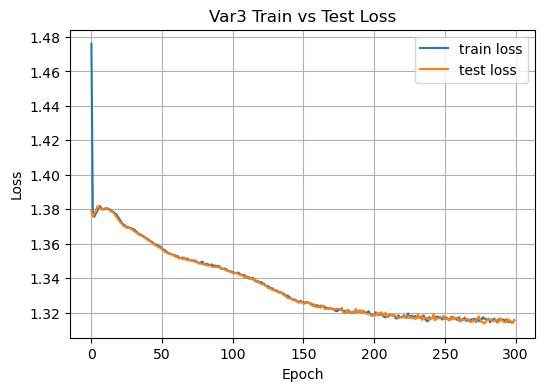

In [124]:
plot_train_test(train_losses_v3, test_losses_v3, title="Var3 Train vs Test Loss")

In [125]:
# Variation 4: lower LR
import torch
import torch.serialization
from torch_geometric.data import Data
from pathlib import Path

print("\n=== Variation 4: GAE (hidden=64, latent=32, lr=0.001) ===")
GrapgAutoEncoder4 = GAE(GAEEncoder(in_channels, hidden_channels, latent_dim))
optimizer_v4 = torch.optim.Adam(GrapgAutoEncoder4.parameters(), lr=0.001)

writer1 = init_writer("Variation4")

train_losses_v4 = []
test_losses_v4 = []

for epoch in range(1, 301):
    train_loss = train(GrapgAutoEncoder4, optimizer_v4, data)
    test_loss  = get_test_loss(GrapgAutoEncoder4, data)

    train_losses_v4.append(train_loss)
    test_losses_v4.append(test_loss)
                          
    log_epoch_losses(writer1, epoch, train_loss, test_loss)

    if epoch % 10 == 0:
        print(f"[Var4] Epoch {epoch:03d}  train_loss={train_loss:.4f}   test_loss={test_loss:.4f}")

writer1.close()

z_v4 = GrapgAutoEncoder4.encode(data.x, data.edge_index)
acc_v4, f1_v4, yPred_v4 = eval_embeddings(z_v4, data)
print("Var4 Accuracy:", acc_v4)
print("Var4 F1 Score:", f1_v4)



=== Variation 4: GAE (hidden=64, latent=32, lr=0.001) ===
[Var4] Epoch 010  train_loss=1.3873   test_loss=1.3834
[Var4] Epoch 020  train_loss=1.3745   test_loss=1.3742
[Var4] Epoch 030  train_loss=1.3750   test_loss=1.3751
[Var4] Epoch 040  train_loss=1.3752   test_loss=1.3750
[Var4] Epoch 050  train_loss=1.3744   test_loss=1.3745
[Var4] Epoch 060  train_loss=1.3739   test_loss=1.3737
[Var4] Epoch 070  train_loss=1.3734   test_loss=1.3735
[Var4] Epoch 080  train_loss=1.3729   test_loss=1.3728
[Var4] Epoch 090  train_loss=1.3722   test_loss=1.3724
[Var4] Epoch 100  train_loss=1.3718   test_loss=1.3716
[Var4] Epoch 110  train_loss=1.3710   test_loss=1.3711
[Var4] Epoch 120  train_loss=1.3704   test_loss=1.3703
[Var4] Epoch 130  train_loss=1.3698   test_loss=1.3694
[Var4] Epoch 140  train_loss=1.3690   test_loss=1.3687
[Var4] Epoch 150  train_loss=1.3683   test_loss=1.3680
[Var4] Epoch 160  train_loss=1.3672   test_loss=1.3673
[Var4] Epoch 170  train_loss=1.3667   test_loss=1.3662
[Var4]

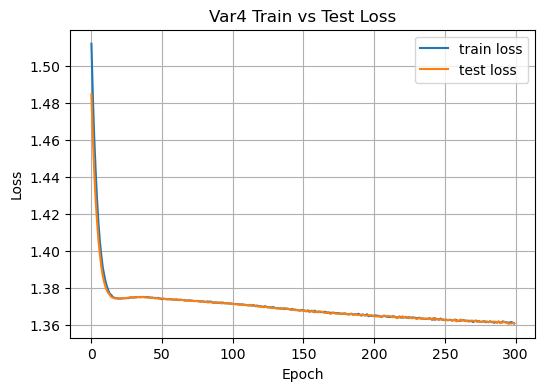

In [126]:
plot_train_test(train_losses_v4, test_losses_v4, title="Var4 Train vs Test Loss")

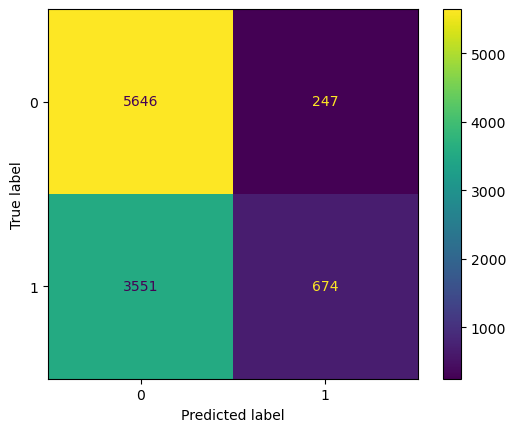

In [127]:
drawConfusion(yTrue, yPred_v3)

# **GIN (Youssef Haitham 233579)**

In [139]:
data.y = data.y.float()

In [140]:
class GIN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout):
        super().__init__()

        nn1 = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        nn2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)

        self.lin_out = nn.Linear(hidden_dim, out_dim)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        out = self.lin_out(x)
        return out.view(-1) 

In [141]:
hps = [
    {"hidden": 32,  "dropout": 0.1, "lr": 0.001},
    {"hidden": 64,  "dropout": 0.2, "lr": 0.0005},
    {"hidden": 128, "dropout": 0.3, "lr": 0.001},
    {"hidden": 256, "dropout": 0.4, "lr": 0.0001},
]

In [142]:
model1 = GIN(data.x.size(1), hps[0]["hidden"], 1, hps[0]["dropout"]).to(device)
model2 = GIN(data.x.size(1), hps[1]["hidden"], 1, hps[1]["dropout"]).to(device)
model3 = GIN(data.x.size(1), hps[2]["hidden"], 1, hps[2]["dropout"]).to(device)
model4 = GIN(data.x.size(1), hps[3]["hidden"], 1, hps[3]["dropout"]).to(device)

opt1 = torch.optim.Adam(model1.parameters(), lr=hps[0]["lr"])
opt2 = torch.optim.Adam(model2.parameters(), lr=hps[1]["lr"])
opt3 = torch.optim.Adam(model3.parameters(), lr=hps[2]["lr"])
opt4 = torch.optim.Adam(model4.parameters(), lr=hps[3]["lr"])

models = [
    ("Model 1", model1, opt1),
    ("Model 2", model2, opt2),
    ("Model 3", model3, opt3),
    ("Model 4", model4, opt4),
]

In [143]:
writer=SummaryWriter("project/tensorboard_logs")

In [144]:
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()

    logits = model(data)                 
    labels = data.y                      
    mask = data.train_mask               

    loss = F.binary_cross_entropy_with_logits(
        logits[mask], labels[mask]
    )

    loss.backward()
    optimizer.step()
    return float(loss)

In [145]:
def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = (logits.sigmoid() > 0.5).float()

        correct = (preds[mask] == data.y[mask]).sum().item()
        total = mask.sum().item()

    return correct / total

In [147]:
accumulated_loss = 0

for name, model, optimizer in models:
    print(f"\n=== {name} ===")

    for epoch in range(1, 201):
        loss = train(model, optimizer, data)
        accumulated_loss += loss
        writer.add_scalar(f"{name}/Loss", accumulated_loss / epoch, epoch)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:02d} | Loss: {loss:.4f}")

    val_acc = evaluate(model, data, data.val_mask)
    test_acc = evaluate(model, data, data.test_mask)

    print(f"Val Acc:  {val_acc:.4f}")
    print(f"Test Acc: {test_acc:.4f}")


=== Model 1 ===
Epoch 10 | Loss: 0.6529
Epoch 20 | Loss: 0.6528
Epoch 30 | Loss: 0.6518
Epoch 40 | Loss: 0.6508
Epoch 50 | Loss: 0.6501
Epoch 60 | Loss: 0.6494
Epoch 70 | Loss: 0.6492
Epoch 80 | Loss: 0.6476
Epoch 90 | Loss: 0.6488
Epoch 100 | Loss: 0.6484
Epoch 110 | Loss: 0.6494
Epoch 120 | Loss: 0.6472
Epoch 130 | Loss: 0.6481
Epoch 140 | Loss: 0.6474
Epoch 150 | Loss: 0.6486
Epoch 160 | Loss: 0.6468
Epoch 170 | Loss: 0.6464
Epoch 180 | Loss: 0.6483
Epoch 190 | Loss: 0.6468
Epoch 200 | Loss: 0.6476
Val Acc:  0.6390
Test Acc: 0.6397

=== Model 2 ===
Epoch 10 | Loss: 0.6559
Epoch 20 | Loss: 0.6537
Epoch 30 | Loss: 0.6522
Epoch 40 | Loss: 0.6522
Epoch 50 | Loss: 0.6522
Epoch 60 | Loss: 0.6507
Epoch 70 | Loss: 0.6493
Epoch 80 | Loss: 0.6495
Epoch 90 | Loss: 0.6500
Epoch 100 | Loss: 0.6510
Epoch 110 | Loss: 0.6474
Epoch 120 | Loss: 0.6476
Epoch 130 | Loss: 0.6478
Epoch 140 | Loss: 0.6478
Epoch 150 | Loss: 0.6460
Epoch 160 | Loss: 0.6457
Epoch 170 | Loss: 0.6476
Epoch 180 | Loss: 0.6450


# **TensorBoard**

In [152]:
%load_ext tensorboard
%tensorboard --logdir runs